# **No Business Like Show Business** - *Film Strategy for Box Office Success*

## Business Understanding

Our company has decided to create a new movie studio, and we have been tasked with analyzing historical box office success and providing actionable insights to guide content production. Our film strategy recommendations focus on key stakeholder questions such as:

- What defines success for a film- does popularity equate to profitability?
- What type of films have historically seen the greatest ROI?
- Do higher production budgets lead to higher revenues?

## Data Understanding

We were provided raw data sets from the movie data sources below, which can be explored further in our 'Data' folder.

- [IMDb](https://www.imdb.com)
    - 'Data/im.db' - SQL database containing movie info and cast & crew details (8 tables)
- [Box Office Mojo](https://www.boxofficemojo.com)
    - 'Data/bom.movie_gross.csv.gz' - domestic and foreign gross revenue (3387 rows x 5 columns)
- [The Numbers](https://www.the-numbers.com)
    - 'Data/tn.movie_budgets.csv.gz' - domestic and worldwide gross revenue, production budget (5782 rows x 6 cols)
- [The Movie DB](https://www.themoviedb.org)
    - 'Data/tmdb.movies.csv.gz' - genre, language, votes/popularity (26517 rows x 10 cols)
- [Rotten Tomatoes](https://www.rottentomatoes.com)
    - 'Data/rt.movie_info.tsv.gz' - synopsis, rating, runtime, etc. (1560 rows x 12 cols)
    - 'Data/rt.reviews.tsv.gz' - reviews and ratings (54432 rows x 8 cols)


Of the described datasets, IMDb and The Numbers provided the most insight for our analysis. 

IMDb contained a SQL database from which we merged two tables to create a dataframe containing movie genre, runtime, release year, and audience ratings.

The Numbers dataset contained movie production budgets and worldwide gross revenues, from which we calculated ROI and merged with IMDb.

## Data Preparation

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
# v2 using imdb 'movie_basics' table only

movie_df = pd.read_csv('Data/movie_clean_v2.csv')
genres_df = pd.read_csv('Data/genres_v2.csv')

### To get a general sense of the market, we looked at the overall count of movies in each genre.

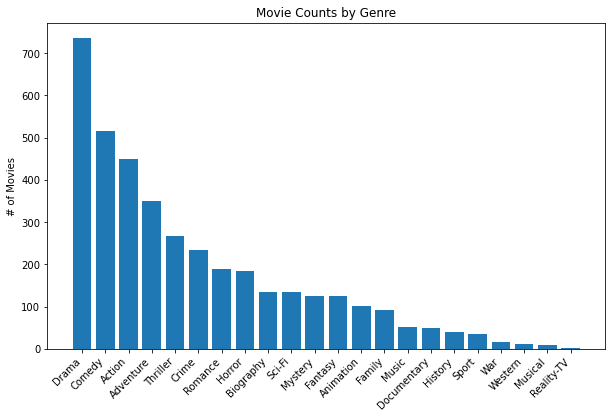

In [3]:
# Movie Counts by Genre - bar chart

genre_counts = genres_df.groupby('genres')['primary_title'].count()
genre_counts = genre_counts.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(genre_counts.index, genre_counts.values)
plt.title('Movie Counts by Genre')
plt.ylabel('# of Movies')
plt.xticks(rotation=45, ha='right')
plt.show()

### The market is heavily saturated with Drama movies followed by Comedy and Action.

### We want to maximize profit so decided to look at top genres through the lens of ROI

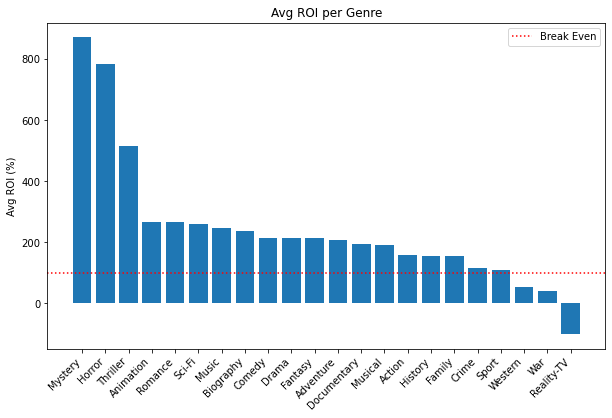

In [4]:
# ROI by Genre - bar chart

genre_roi = genres_df.groupby('genres')['ROI'].mean()
genre_roi = genre_roi.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(genre_roi.index, genre_roi.values)
plt.axhline(y=100, color='red', ls ='dotted', label='Break Even')
plt.title('Avg ROI per Genre')
plt.ylabel('Avg ROI (%)')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()

### After sorting by ROI, we found that Mystery, Horror, and Thriller movies had a higher average compared to other genres.

- Crime, Sport - barely break even
- Western, War - too niche

### Focusing on these three genres, we looked at the average runtime vs that of all films.

In [5]:
def plot_genres_runtime(input_genres):
    
    # Define list of allowed genres
    allowed_genres = list(genres_df['genres'].value_counts().sort_index().index)
    
    # Check if input_genres is a list
    if not isinstance(input_genres, list):
        raise ValueError("Input input_genres must be a list.")

    # Check if all genres in input_genres are allowed
    for genre in input_genres:
        if genre not in allowed_genres:
            raise ValueError(f"Invalid genre: {genre}. Allowed genres are {allowed_genres}.")
  
    # Create chart
    plt.figure(figsize=(10, 6))
    plt.title('Runtime Distribution by Genre')
    plt.xlabel('Runtime (minutes)')
    plt.ylabel('Probability Density')

    # Plot bell curve for overall movies runtime
    mean = movie_df['runtime_minutes'].mean()
    std_dev = movie_df['runtime_minutes'].std()
    x = np.linspace(mean-(4*std_dev), mean+(4*std_dev))
    y = norm.pdf(x, mean, std_dev)
    plt.plot(x, y, label='All Movies', color='black')

    # Calculate data and plot for each input genre
    for genre in input_genres:
        mean_genre = genres_df.loc[genres_df['genres'] == genre, 'runtime_minutes'].mean()
        std_dev_genre = genres_df.loc[genres_df['genres'] == genre, 'runtime_minutes'].std()
        x_genre = np.linspace(mean_genre-(4*std_dev_genre), mean_genre+(4*std_dev_genre))
        y_genre = norm.pdf(x_genre, mean_genre, std_dev_genre)
        plt.plot(x_genre, y_genre, label=genre)

    # Show chart  
    plt.legend()
    plt.grid()
    plt.show()


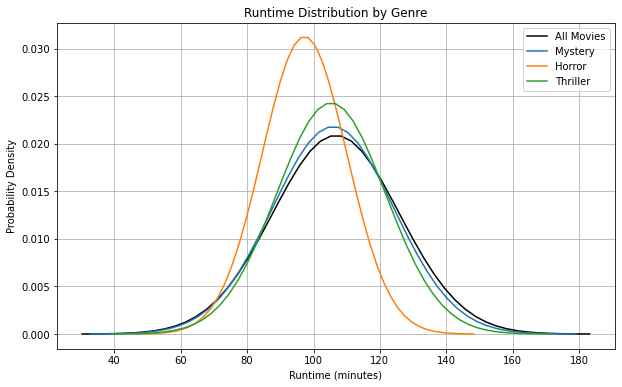

In [6]:
input_genres = ['Mystery', 'Horror', 'Thriller']
plot_genres_runtime(input_genres)

In [32]:
from sklearn.linear_model import LinearRegression

X = movie_df[['production_budget']]
y = movie_df['worldwide_gross']

# Create and fit the model
model = LinearRegression()
model.fit(X, y)

# Calculate the R-squared
r_squared = model.score(X, y)

print(f"R-squared: {r_squared}")

R-squared: 0.6220875847355631


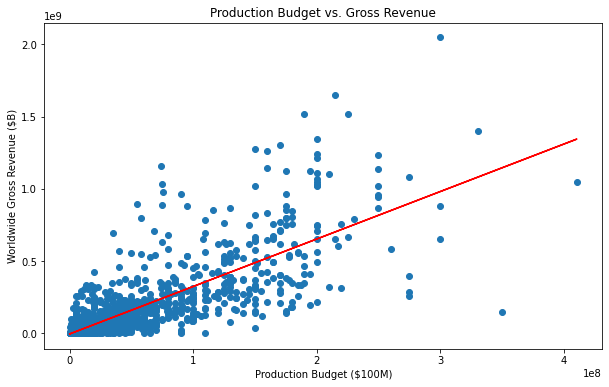

In [35]:
# Budget vs. Revenue - scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(movie_df['production_budget'], movie_df['worldwide_gross'])
plt.title('Production Budget vs. Gross Revenue')
plt.xlabel('Production Budget ($100M)')
plt.ylabel('Worldwide Gross Revenue ($B)')

# Add regression line
plt.plot(X, model.predict(X), color='red', label='Regression')

plt.show()


## Analysis and Results

### Business Recommendation 1

Genre Rrecommendation: 
    To ensure the success of the new movie studio, we recommend a strategic move to create a movie combining the horror mystery and thriller genres. Our finding has shown highest percentage of Return on Investment for these genres. Making them a reliable choice for establishing our studio's presence and guarante the satisfaction of all stakeholders involved in the project. 

### Business Recommendation 2

Runtime recommendation: Based on our finding of succesful movies, we recommend maintaining an average runtime 
under 2 hours. Keeping the movie concise, ensures ensure their aligment with audience preference and maximize their potential reach and impact. 

### Business Recommendation 3

Budget recommendation: We recommend the studio to strategically manage the financial risk by adopting a low budget approach. Our data have identified movie labeled as Ultra-Low investment with a high Return on Investment ROI. Aiming for a lean budget minimize financial exposure while encouraging innovative storytelling

## Conclusion

we are looking at movies with the highest ROI
so we can minimize financial risk and maximize monetary gains

genre
    what genres have historically had the highest roi
    - bar chart - genre vs ROI - highlight top 3-5 genres
    - chart comparing top genres by budget bins

runtime
- look at the movies with highest ROI and find upper/lower limits for runtime
 - find the confidence interval for 
 - bell curve of runtime ?

budget
- production budget vs ROI - range of bdugets to maximize ROI
 



### Next Steps